<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 语义分割（semantic segmentation）(仅了解了一下)
> 语义分割重点关注于如何将图像分割成属于不同语义类别的区域。与⽬标检测不同，语义分割可以识别并理解图像中每⼀个像素的内容：其语义区域的标注和预测是像素级的。

##图像分割和实例分割
&emsp;&emsp;他们两之间的区别：
> *  图像分割将图像划分为若⼲组成区域，这类问题的⽅法通常利⽤图像中像素之间的相关性。它在训练
时不需要有关图像像素的标签信息，在预测时也⽆法保证分割出的区域具有我们希望得到的语义。只表示这个像素块是哪一类。
* 实例分割也叫同时检测并分割（simultaneous detection and segmentation），它研究如何识别图像中各个⽬标实例的像素级区域。与语义分割不同，实例分割不仅需要区分语义，还要区分不同的⽬标实例。表示这个像素块属于哪一类的哪一个实例物体。

![](http://jx.anderd.com/docker/SegVSS.png)

In [ ]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [ ]:
#语义分割数据集
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l


In [ ]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
'4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [ ]:
def read_voc_images(voc_dir,is_train=True):
  """读取所有voc图像并标注"""
  txt_fname = os.path.join(voc_dir,'ImageSets','Segmentation',
                           'train.txt'if is_train else 'val.txt')
  mode = torchvision.io.image.ImageReadMode.RGB
  with open(txt_fname,'r')as f:
    images = f.read().split()
  features,labels = [],[]
  for i,fname in enumerate(images):
    features.append(torchvision.io.read_image(os.path.join(voc_dir,'JPEGImages',f'{fname}.jpg')))
    labels.append(torchvision.io.read_image(os.path.join(voc_dir,'SegmentationClass',f'{fname}.png'),mode))
  return features,labels

In [ ]:
train_features, train_labels = read_voc_images(voc_dir, True)#训练数据集

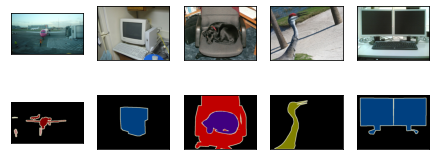

In [ ]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],[0, 64, 128]]
              
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [ ]:
def voc_colormap2label():
  """构建从RGB到VOC类别索引的映射"""
  colormap2label = torch.zeros(256 ** 3,dtype=torch.long)#将图片的rgb值映射到一个标号上
  for i,colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
  return colormap2label#字典

def voc_label_indices(colormap, colormap2label):
  """将VOC标签中的RGB值映射到它们的类别索引。"""
  colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
  idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256+ colormap[:, :, 2])
  return colormap2label[idx]

In [ ]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]#在第⼀张样本图像中，⻜机头部区域的类别索引为1，而背景索引为0

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]), 'aeroplane')

In [ ]:
def voc_rand_crop(feature, label, height, width):
  """随机裁剪特征和标签图像。"""
  rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
  feature = torchvision.transforms.functional.crop(feature, *rect)
  label = torchvision.transforms.functional.crop(label, *rect)
  return feature, label

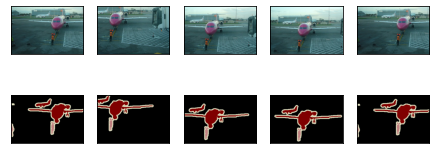

In [ ]:
imgs = []
for _ in range(n):
  imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [ ]:
#自定义语义分割数据集类
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集。"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float())

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [ ]:
#读取数据集
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [ ]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [ ]:
#整合所有组件
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集。"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

##小结

* 语义分割通过将图像划分为属于不同语义类别的区域，来识别并理解图像中像素级别的内容。
* 语义分割的一个重要的数据集叫做Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，输入图像会被随机裁剪为固定尺寸而不是缩放。

#转置卷积

&emsp;&emsp;由于之前的卷积层和汇聚层，都是下采样，减少输入图像的空间维度，那有没有一种办法来扭转下采样导致的空间尺寸减小？那就是**转置卷积**

> 转置卷积是一种卷积
* 它将输入和核进行了重新排列
* 同卷积一般是做下采样，它通常用作上采样
* 如果卷积将输入从(h,w)变成了(h',w')，同超参数下它将(h',w')变成(h,w)

![](http://pan.anderd.com/download/6167976b7e1b65005937fdbd)

In [1]:
!pip install -U d2l

     |████████████████████████████████| 83 kB 1.2 MB/s 


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#基本操作
![转置卷积](http://pan.anderd.com/download/6166a4c10141ac0059b2e6a9)



In [ ]:
def trans_conv(X,K):
  h,w = K.shape
  Y = torch.zeros((X.shape[0] + h - 1,X.shape[1] + w - 1))#结果矩阵初始化0
  for i in range(Y.shape[0]-1):
    for j in range(Y.shape[1]-1):
      Y[i:i+h,j:j+w] += X[i,j] * K#这里通过卷积核广播输入元素，从而产生大于输如的输出
  return Y

In [ ]:
X = torch.tensor([[0.0,1.0],[2.0,3.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
trans_conv(X,K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [ ]:
#当输入室四维是可以用api
X,K = X.reshape(1,1,2,2),K.reshape(1,1,2,2)
tconv = nn.ConvTranspose2d(1,1,kernel_size=2,bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<SlowConvTranspose2DBackward>)

## 填充，步幅，多通道

&emsp;&emsp;与常规卷积不同，在转置卷积中，填充被应⽤于输出（常规卷积将填充应⽤于输⼊）。例如，当将⾼和宽两侧的填充数指定为1时，转置卷积的输出中将删除第⼀和最后的⾏与列。

In [ ]:
tconv = nn.ConvTranspose2d(1,1,kernel_size=2,padding=1,bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<SlowConvTranspose2DBackward>)

&emsp;&emsp;在转置卷积中，步幅被指定为中间结果（输出），而不是输⼊。可能会增加高和权重。
![步幅](http://pan.anderd.com/download/6166ab30cc52c6005925ceca)

In [ ]:
tconv = nn.ConvTranspose2d(1,1,kernel_size=2,stride=2,bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<SlowConvTranspose2DBackward>)

&emsp;&emsp;对于多个输⼊和输出通道，转置卷积与常规卷积以相同⽅式运作。

In [ ]:
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)
tconv(conv(X)).shape == X.shape

True

##与矩阵变换的联系

In [ ]:
X = torch.arange(9.0).reshape(3, 3)#使⽤矩阵乘法来实现卷积。
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Y

tensor([[27., 37.],
        [57., 67.]])

In [ ]:
def kernel2matrix(K):#将卷积核K重写为包含⼤量0的稀疏权重矩阵W。权重矩阵的形状是（4，9），其中⾮0元素来⾃卷积核K。
  k, W = torch.zeros(5), torch.zeros((4, 9))
  k[:2], k[3:5] = K[0, :], K[1, :]
  W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
  return W
W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

&emsp;&emsp;逐⾏连接输⼊X，获得了⼀个⻓度为9的⽮量。然后，W的矩阵乘法和向量化的X给出了⼀个⻓度为4的向量。重塑它之后，可以获得与上⾯的原始卷积操作所得相同的结果Y：我们刚刚使⽤矩阵乘法实现了卷积。

In [ ]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

In [ ]:
#使⽤矩阵乘法来实现转置卷积
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

##小结
* 与通过卷积核减少输⼊元素的常规卷积相反，转置卷积通过卷积核⼴播输⼊元素，从而产⽣形状⼤于输⼊的输出。
* 如果我们将 X 输⼊卷积层 f 来获得输出 Y = f(X) 并创造⼀个与 f 有相同的超参数、但输出通道数是 X中通道数的转置卷积层 g，那么 g(Y ) 的形状将与 X 相同。
* 我们可以使⽤矩阵乘法来实现卷积。转置卷积层能够交换卷积层的正向传播函数和反向传播函数。

#全卷积网络（FCN）
&emsp;&emsp;全卷积神经网络实现了从图像到像素类别的变换，全卷积网络将中间特征层的高和宽恢复到输入图像的尺寸，是通过最后的转置卷积实现的。所以，输出类别预测与输入图像在像素级别上具有一一对应的关系。给定空间维上的位置，通道维的输出即该位置对应像素的类别预测。


![FCN](http://pan.anderd.com/download/6167a23c3a3b95005900f693)

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
#模型构造
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [4]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])#复制了Resnet18中的预训练层，但除去了最终的全局平均汇聚层和最接近输出的全连接层
X = torch.rand(size=(1,3,320,480))
net(X).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 512, 10, 15])

In [5]:
num_classes = 21
net.add_module('final_conv',nn.Conv2d(512,num_classes,kernel_size=1))#使⽤1 × 1卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）
net.add_module('transpose_conv',nn.ConvTranspose2d(num_classes,num_classes,
                        kernel_size=64,padding=16,stride=32))#将要素地图的⾼度和宽度增加32倍，从而将其变回输⼊图像的⾼和宽。

> 步幅为s，填充为$\frac{s}{2}$,且卷积核的高和宽为2s，转置卷积核会将输入的高和宽分别放大s倍

In [6]:
#初始化转置卷积层，双线性插值是常用的上采样方法

def bilinear_kernel(in_channels,out_channels,kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5
  og = (torch.arange(kernel_size).reshape(-1,1),torch.arange(kernel_size).reshape(1,-1))
  filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
  weight = torch.zeros((in_channels,out_channels,kernel_size,kernel_size))
  weight[range(in_channels),range(out_channels),:,:] = filt
  return weight

In [7]:
#实现用双线性插值初始化转置卷积weight
conv_trans = nn.ConvTranspose2d(3,3,kernel_size=4,padding=1,stride=2,bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3,3,4));

input image shape: torch.Size([336, 440, 3])
output image shape: torch.Size([672, 880, 3])


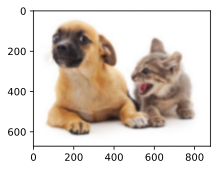

In [10]:
#测试上采样
img = torchvision.transforms.ToTensor()(d2l.Image.open('/home/catdog.png'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1,2,0).detach()

d2l.set_figsize()
print('input image shape:',img.permute(1,2,0).shape)
d2l.plt.imshow(img.permute(1,2,0));
print('output image shape:',out_img.shape)
d2l.plt.imshow(out_img);
#双线性插值放⼤的图像原图看上去没什么两样。

In [8]:
#转置卷积用双线性插值初始化参数，对于1x1卷积层，我们使用Xavier初始化参数
W = bilinear_kernel(num_classes,num_classes,64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [9]:
#读取数据集
batch_size, crop_size = 32, (320,480)
train_iter ,test_iter = d2l.load_data_voc(batch_size,crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


loss 0.417, train acc 0.869, test acc 0.850
37.7 examples/sec on [device(type='cuda', index=0)]


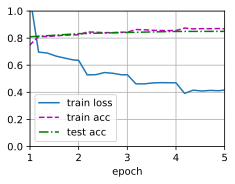

In [11]:
#训练 
def loss(inputs,targets):
  return F.cross_entropy(inputs,targets,reduction='none').mean(1).mean(1)

num_epochs, lr, wd,devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(),lr=lr,weight_decay=wd)
d2l.train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices)

In [13]:
#预测
def predict(img):
  X = test_iter.dataset.normalize_image(img).unsqueeze(0)
  pred = net(X.to(devices[0])).argmax(dim=1)
  return pred.reshape(pred.shape[1],pred.shape[2])

In [14]:
def label2image(pred):
  colormap = torch.tensor(d2l.VOC_COLORMAP,device=devices[0])
  X = pred.long()
  return colormap[X,:]

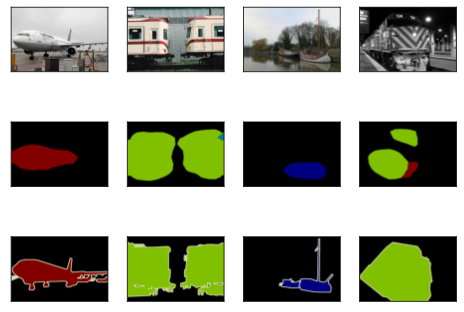

In [18]:
voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')
test_images,test_labels = d2l.read_voc_images(voc_dir,False)
n, imgs = 4, []
for i in range(n):
  crop_rect = (0,0,320,480)
  X = torchvision.transforms.functional.crop(test_images[i],*crop_rect)
  pred = label2image(predict(X))
  imgs += [X.permute(1,2,0),pred.cpu(),torchvision.transforms.functional.crop(
      test_labels[i],*crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3]+imgs[1::3]+imgs[2::3],3,n,scale=2);

##小结
* 全卷积⽹络先使⽤卷积神经⽹络抽取图像特征，然后通过1 × 1卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的⾼和宽变换为输⼊图像的尺⼨。
* 在全卷积⽹络中，我们可以将转置卷积层初始化为双线性插值的上采样。